In [1]:
%load_ext autoreload
%autoreload 2

import adi
import matplotlib.pyplot as plt
import numpy as np
import scipy
from IPython import display
from ofdm_transceiver import *


NUM_BITS_PER_SYMBOL = 2
sample_rate = 5e6  
center_freq = 2.0e9

delta_t = 1 / sample_rate
delta_f = 30e3 
frac_guard = 0.5

N_sc_av = int(sample_rate / delta_f)
N_fft =  2**(int(np.log2(N_sc_av))) 
N_sc_use = int( N_fft * frac_guard)
guard_length = int( 0.5 * N_fft )
CP_len = int(N_fft * 0.2 ) 
#num_bits_sym = 1

do_cfo_corr = 1
do_ce = 1
dc_offset = 0

### TX data

In [114]:
np.random.seed(123); tf.random.set_seed(123)
# create preamble 
preamble = create_preamble(N_fft, CP_len, 2)
# create pilot symbol
qam_symb_pilot = qam_modulate(generate_bits(N_sc_use, NUM_BITS_PER_SYMBOL), NUM_BITS_PER_SYMBOL)
ofdm_symb_pilot = form_baseband_ofdm_symb(qam_symb_pilot, N_fft, CP_len, False)
# create data symbols
bits = generate_bits(N_sc_use, NUM_BITS_PER_SYMBOL)
qam_symb = qam_modulate(bits, NUM_BITS_PER_SYMBOL)
ofdm_symb = form_baseband_ofdm_symb(qam_symb, N_fft, CP_len, False)
# guard interval
guard = np.zeros((guard_length, 1), dtype=np.complex64)

frame = np.concatenate((preamble, ofdm_symb_pilot[:,None], ofdm_symb[:,None], guard))
repeated_frame = np.tile(frame, reps= (3,1))

frame_len = len(frame)
preamble_len = N_fft//2

### SDR init

In [ ]:
sdr = adi.ad9361(uri='ip:192.168.1.1')

# RX config
sdr.rx_enabled_channels = [0, 1]
sdr.gain_control_mode_chan0 = "slow_attack"  # manual/slow_attack/fast_attack
sdr.gain_control_mode_chan1 = "slow_attack"
if sdr.gain_control_mode_chan0 == "manual": # set rx gain if AGC is turned off
    sdr.rx_hardwaregain_chan0 = 70 # dB
if sdr.gain_control_mode_chan1 == "manual":
    sdr.rx_hardwaregain_chan1 = 70 # dB
sdr.rx_lo = int(center_freq)
sdr.sample_rate = int(sample_rate)          # must be <=30.72 MHz if both channels are enabled
sdr.rx_rf_bandwidth = int(sample_rate)
sdr.rx_buffer_size = len(repeated_frame)  

# TX config
sdr.tx_enabled_channels = [0]
sdr.tx_lo = int(center_freq)
sdr.tx_rf_bandwidth = int(sample_rate)
sdr.tx_hardwaregain_chan0 = -50 # valid range is -90 to 0 dB
#sdr.tx_hardwaregain_chan1 = -50 # valid range is -90 to 0 dB

sdr.tx_cyclic_buffer = True # Enable cyclic buffers
sdr.tx(repeated_frame.ravel() * 2**14) # start transmitting

In [ ]:
# load channel samples from file
data_X = np.load('recorded_data/chan.npy')

In [ ]:
rx_qam = []
for ci in range(500):
    data = data_X[ci]
    rx_sig = svd_combining(data) #data[0] + data[1]
    rx_len = len(rx_sig) 

    idx_max, corr_value = find_edges(rx_sig, frame_len, preamble_len, start_idx = 0, CP_len = CP_len)
    frame_receive = rx_sig[idx_max : idx_max + frame_len]

    frame_receive = cfo_compensate(frame_receive, corr_value, preamble_len) if do_cfo_corr else frame_receive
    pilot_receive = frame_receive[N_fft + CP_len : 2*N_fft + CP_len]

    pilot_freq = np.fft.fft(pilot_receive, N_fft, 0, norm = "ortho")
    rec_sym_pilot = baseband_freq_domian(pilot_freq, N_sc_use)

    # apply CE
    h_ls = rec_sym_pilot.ravel() / qam_symb_pilot.ravel()
    h_ls = channel_estimation(h_ls, CP_len, N_fft) if do_ce else h_ls

    rec_data_sym = frame_receive[2 * (N_fft + CP_len) : 2 * (N_fft + CP_len) + N_fft]
    rec_data_sym_freq = np.fft.fft(rec_data_sym, N_fft, 0, norm="ortho")
    rec_sym_data = baseband_freq_domian(rec_data_sym_freq, N_sc_use)
    eq_data = rec_sym_data[:, 0] / h_ls

    rx_qam.append(eq_data)
    bit_arr = qam_demodulate(eq_data.astype(np.complex64), NUM_BITS_PER_SYMBOL)
    ber = get_ber(bits[:,None], bit_arr, N_sc_use)
    SNR_est = estimate_SNR(pilot_freq, rec_sym_pilot, N_sc_use)

    #bers.append(ber)
rx_qam = np.array(rx_qam)

Text(0, 0.5, 'imag')

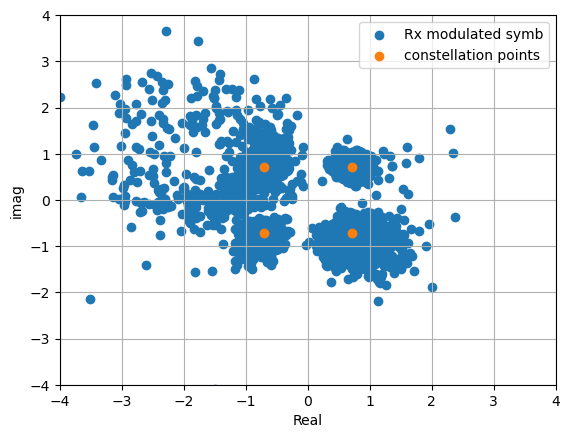

In [119]:
const = np.unique(qam_symb_pilot)
plt.scatter(np.real(rx_qam.ravel()), np.imag(rx_qam.ravel()), label = 'Rx modulated symb')
plt.scatter(np.real(const), np.imag(const), label = 'constellation points')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.grid(); plt.legend(); plt.xlabel("Real"); plt.ylabel("imag")

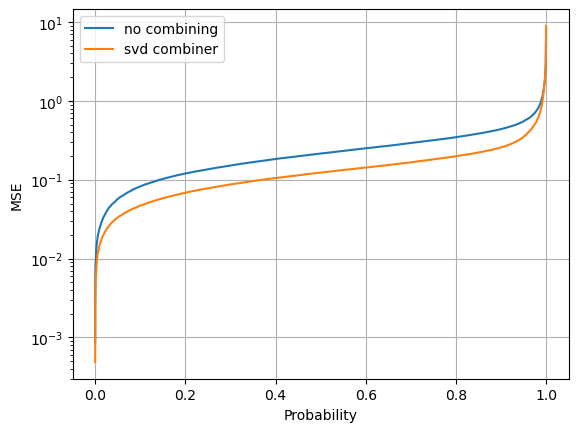

In [116]:
error = np.min(np.abs(rx_qam.reshape(-1,1) - const.reshape(1,-1)),axis = 1)

plt.semilogy(np.linspace(0,1,len(baseline)), sorted(baseline), label = 'no combining')
plt.semilogy(np.linspace(0,1,len(error)), sorted(error), label = 'svd combiner')
plt.ylabel('MSE'); plt.xlabel('Probability'); plt.grid(); plt.legend()